In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False
from tqdm import tqdm

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
df.date_time = pd.to_datetime(df.date_time)

In [4]:
df_1 = df[df['num']==1]

In [5]:
df_1

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2035,1,2020-08-24 19:00:00,8714.952,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,1,2020-08-24 20:00:00,8740.224,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,1,2020-08-24 21:00:00,8730.504,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,1,2020-08-24 22:00:00,8725.968,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [6]:
df_1 = df_1.set_index(['date_time'])

<Axes: xlabel='date_time'>

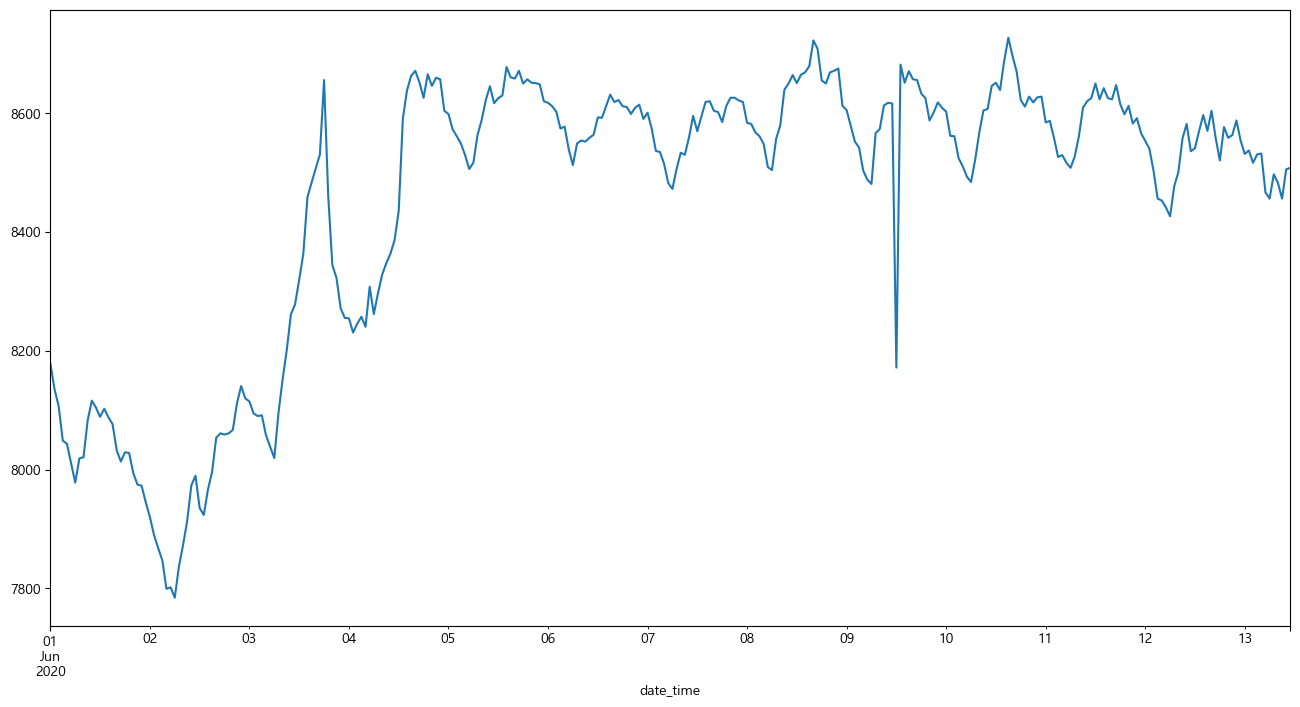

In [7]:
df_1.iloc[:300,1].plot(figsize=(16,8))

<Axes: xlabel='date_time'>

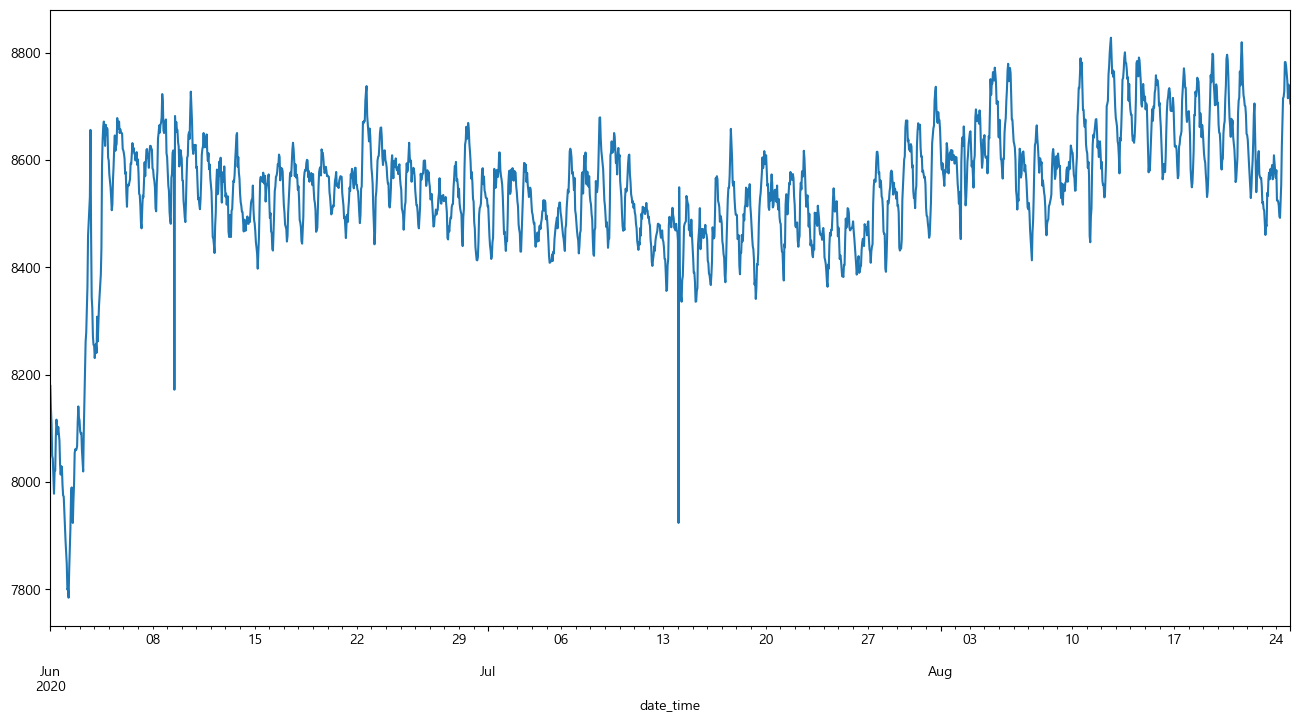

In [8]:
df_1['전력사용량(kWh)'].plot(figsize=(16,8))

In [9]:
group = df.groupby(['num','date_time']).mean()

<Axes: xlabel='num', ylabel='전력사용량(kWh)'>

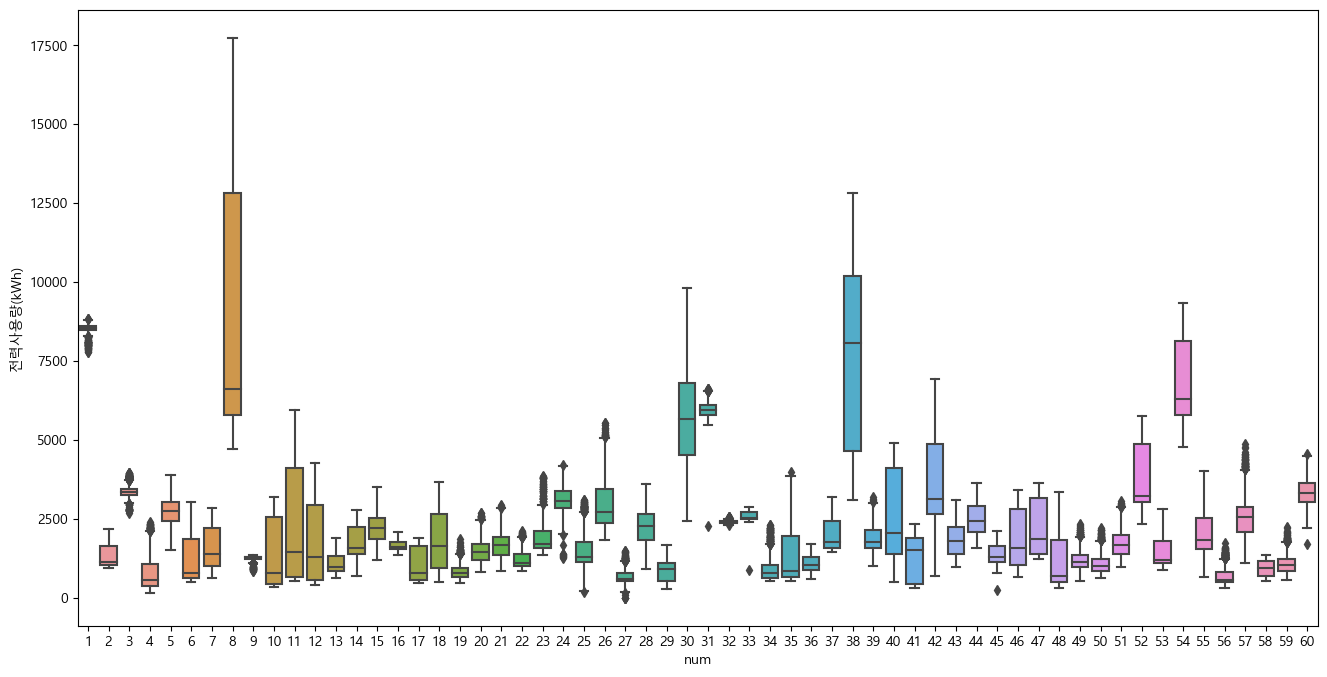

In [10]:
plt.figure(figsize=(16,8))
sns.boxplot(x='num', y='전력사용량(kWh)', data=df)

<Axes: xlabel='date_time', ylabel='전력사용량(kWh)'>

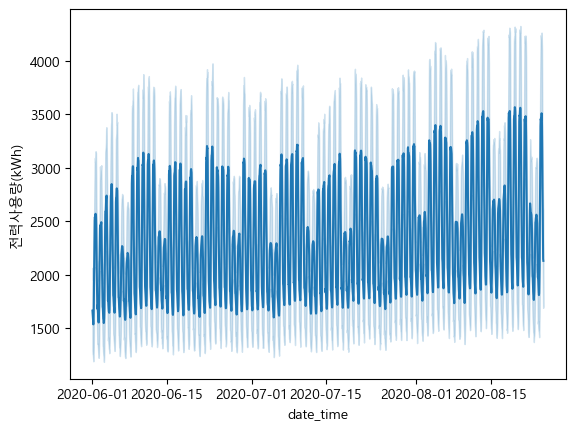

In [11]:
sns.lineplot(x='date_time', y='전력사용량(kWh)', data = df.groupby(['num','date_time']).mean())

In [12]:
eda_df = df.copy()

In [13]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [14]:
import datetime

In [15]:
days = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

In [16]:
for i in tqdm(range(len(eda_df))):
    eda_df['month'][i] = eda_df.date_time[i].month
    eda_df['hour'][i] = eda_df.date_time[i].hour
    eda_df['year'][i] = eda_df.date_time[i].year
    eda_df['day'][i] = eda_df.date_time[i].day
    eda_df['요일'][i] = days[eda_df.date_time[i].weekday()]

100%|██████████| 122400/122400 [01:09<00:00, 1769.16it/s]


In [19]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [21]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [22]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [23]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [24]:
total_df.reset_index(inplace=True)

In [25]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

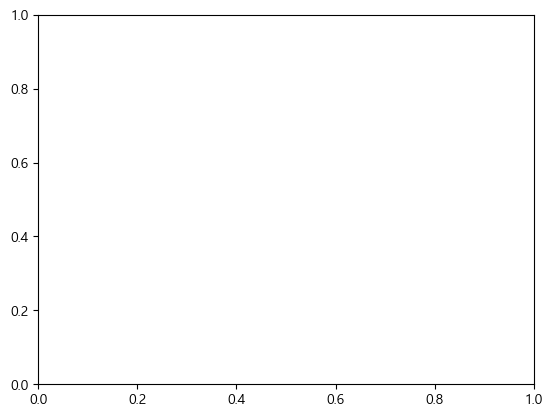

In [119]:
for i in range(1,61):
    sns.boxplot(x = '요일', y = '전력사용량(kWh)', data = eda_df[eda_df['num'] == i])
    plt.title('{} 기업 요일별 전력사용량'.format(i))
    plt.savefig('./energy_plot/요일별_전력사용량_{}.png'.format(i))
    plt.cla()
    for j in days:
        sns.boxplot(x = 'hour', y = '전력사용량(kWh)', data = eda_df[(eda_df['num'] == i) & (eda_df['요일'] == j)])
        plt.title('{} 기업 {} 요일 시간별 전력사용량'.format(i,j))
        plt.savefig('./energy_plot/{} 기업 {} 시간별 전력사용량.png'.format(i,j))
        plt.cla()

In [34]:
# 예측 모형
def predict(data, mean, std):
    # 각 시간마다 평균값과 분산을 다르게 설정
    predicted_values = []
    for i in range(len(data)):
        # 각 시간마다 평균값과 분산 설정
        mu_i = mean[i % 12]
        std_i = std[i % 12]

        # 예측값 계산
        y_i = np.random.normal(mu_i, std_i)
        predicted_values.append(y_i)

    return predicted_values

# 예측값 출력
#predicted_values = predict(data)